
# Exercise 1: Risk Analysis for an Investor in the Utilities Sector

An investor is considering investing in assets from the S&P 500, particularly within the Utilities sector, but is concerned about the potential risk of daily losses. To help the investor make an informed decision, you will conduct an analysis to determine which assets in this sector pose the highest and lowest risk, measured by the maximum potential daily loss with a 95% confidence level, based on historical data.

Using the file componentes_sp500.xlsx (sheet: sp500), focus on the GICS_sector column to identify assets in the Utilities sector and extract their tickers from the Symbol column. Stored the tickers in a list variable named **utility_tickers** Then, download their historical Adjusted Close prices from Yahoo Finance for the period 2010-01-01 to 2020-12-31 and identify:

- The stock with the highest daily loss.

- The stock with the lowest daily loss.

Cretae a list named **loss_tickers** with the tickers of these two assets.
  
For the two selected assets, provide the following information:

- Ticker

- Company name

- Subindustry

- Date added to the S&P 500

- Maximum daily loss, calculated at the 95% confidence level, based on historical values.

- Annual expected return

Store the results for these two assets in a list of dictionaries named **results** with the above information as key-value pairs.

**Before performing any calculations, drop any assets that have missing values during this period**.

After completing this analysis, calculate the potential daily losses for the same two assets using a 97% confidence level. This time, instead of the historical approach, use a parametric approach.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from scipy.stats import norm

In [7]:
# Load the data
sp500_components = pd.read_excel('./components_sp500.xlsx', sheet_name='sp500', skiprows=3)

# Filter for Utilities sector
utility_tickers = sp500_components[sp500_components['GICS_Sector'] == 'Utilities']['Symbol'].to_list()

start_date = '2010-01-01'
end_date = '2020-12-31'

# Download Adjusted Close prices from Yahoo Finance
data = yf.download(utility_tickers, start=start_date, end=end_date)['Adj Close']

# Drop assets with missing data
data.dropna(axis=1, how='any', inplace=True)

# Calculate daily log returns
data_returns = np.log(data).diff().dropna()

# Calculate 5% historical VaR (Value at Risk) for each asset
var_95 = data_returns.quantile(0.05)

# Find tickers with the highest and lowest potential daily loss
loss_tickers = [var_95.idxmin(), var_95.idxmax()]  # [max_loss_ticker, min_loss_ticker]

# Calculate annual expected return (assuming 252 trading days)
annual_return = data_returns.mean() * 252

# Create a list of dictionaries to store results using f-strings for formatting
results = []
for ticker in loss_tickers:
    asset_info = sp500_components[sp500_components['Symbol'] == ticker].iloc[0]
    results.append({
        'Ticker': ticker,
        'Company name': asset_info['Company_Name'],
        'Subindustry': asset_info['GICS_Sub-Industry'],
        'Date added': asset_info['Date_added'],
        'Maximum daily loss (5%)': f"{100 * var_95[ticker]:.2f}",  # Format as a string with 2 decimals
        'Annual expected return': f"{100 * annual_return[ticker]:.2f}"  # Format as a string with 2 decimals
    })

# Parametric VaR at 97% confidence interval (assuming normal distribution)
mean_returns = data_returns.mean()
std_returns = data_returns.std()

# Calculate parametric VaR for 99% confidence interval
var_97_parametric = mean_returns + norm.ppf(0.03) * std_returns

# Append the parametric VaR (99%) for the two selected assets
for ticker in loss_tickers:
    for result in results:
        if result['Ticker'] == ticker:
            result['Maximum daily loss (97%) Parametric'] = f"{100 * var_97_parametric[ticker]:.2f}"  # Format with 2 decimals

# Display the updated results
results

[*********************100%***********************]  31 of 31 completed

1 Failed download:
['CEG']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2020-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1262322000, endDate = 1609390800")')


[{'Ticker': 'NRG',
  'Company name': 'NRG Energy',
  'Subindustry': 'Independent Power Producers & Energy Traders',
  'Date added': '2010-01-29',
  'Maximum daily loss (5%)': '-3.19',
  'Annual expected return': '5.13',
  'Maximum daily loss (97%) Parametric': '-4.19'},
 {'Ticker': 'SO',
  'Company name': 'Southern Company',
  'Subindustry': 'Electric Utilities',
  'Date added': '1957-03-04',
  'Maximum daily loss (5%)': '-1.53',
  'Annual expected return': '10.12',
  'Maximum daily loss (97%) Parametric': '-2.25'}]

# Exercise 2:

As a financial advisor, your goal is to guide an investor looking to optimize their investment in a specific asset from the S&P 500 index. The investor wants to make decisions based on a weekly and monthly analysis of the asset’s returns and needs to know which frequency is best for maximizing risk-adjusted returns. To achieve this, follow these steps:

1. **Load and clean the data**:
   - Load the file **sp500_adj_close.csv** (provided) and select the data from **2019** onward (inclusive).
   - **First**, remove all assets (columns) that have more than 20% missing data.
   - **Then**, remove any remaining rows with missing values for the selected assets.

2. **Calculate logarithmic returns**:
   - Compute the daily logarithmic returns for the remaining assets.
   - Filter out the assets with a daily average return less than or equal to zero.

3. **Select the asset with the best return per unit of risk**:
   - Calculate the **annualized return** and the **annualized volatility** for the filtered assets.
   - Select the asset with the highest **ratio of annualized return to annualized volatility**, i.e., the asset that provides the best return per unit of risk taken.

4. **Weekly and monthly analysis of the selected asset**:
   - Resample the returns of the selected asset to **weekly** and **monthly** frequencies.
   - Generate a histogram with both the weekly and monthly returns, normalizing the frequencies to visually compare them.

5. **Calculate key statistics**:
   - Compute the **annualized mean**, **annualized volatility**, **skewness**, and **kurtosis** for the weekly and monthly returns of the selected asset.
   - Present these results in a **DataFrame** to compare the statistics across both frequencies.

6. **Analyze the impact of frequency**:
   - Conduct a **detailed analysis** of how **weekly** and **monthly** frequencies impact each of the calculated metrics (mean, volatility, skewness, and kurtosis).
   - Discuss how each statistic varies between the two frequencies and what implications this has for the investor’s decision-making process.

This exercise will allow you to compare the characteristics of the asset’s returns across different time horizons and conduct a thorough analysis of the impact of frequency, helping you provide valuable advice to the investor on the most suitable investment strategy.



/tmp/ipykernel_4494/3589474655.py:45: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ret_mayor_mes = ret_mayor.resample('M').first()


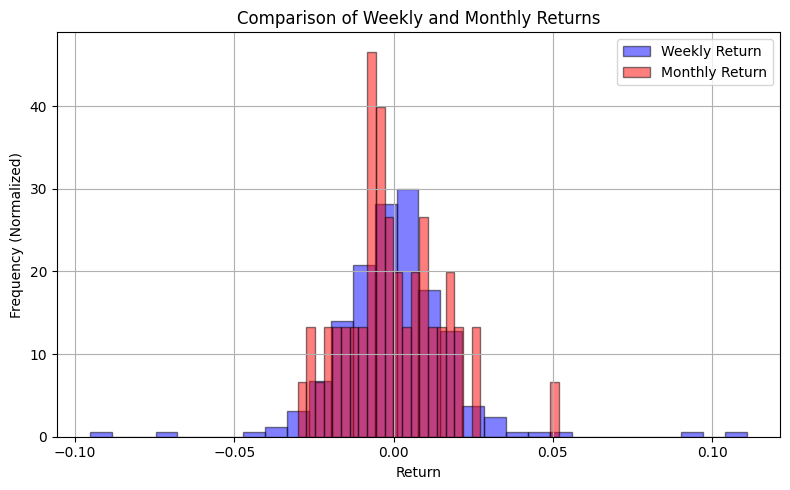

In [8]:
# Load the adjusted closing price data from the CSV file, skipping the first two rows, 
# setting the first column as the index, and parsing the index as dates.
price_data = pd.read_csv("/workspace/data/sp500_adj_close.csv", skiprows=2, index_col=0, parse_dates=True)

# Remove the last row of the DataFrame (if it's summary or irrelevant data).
price_data = price_data.iloc[:-1,]

# Convert the index (which contains dates) to datetime format.
price_data.index = pd.to_datetime(price_data.index)

# Filter the data to only include rows starting from the year 2019 onwards.
price_data = price_data.loc['2019':, :]

# Calculate the percentage of missing values (NaNs) in each column.
missing_percentage = price_data.isna().mean()

# Filter out columns that have more than 20% missing values, keeping columns with 20% or less missing values.
price_data_cleaned = price_data.loc[:, missing_percentage <= 0.2]

# Drop any remaining rows that contain missing values in any column.
price_data_cleaned = price_data_cleaned.dropna(axis=0, how='any')

# Calculate the logarithmic returns of the cleaned data and remove any NaN values.
returns = np.log(price_data_cleaned).diff().dropna()

# Keep only the columns (assets) where the mean return is greater than 0.
returns = returns.loc[:, returns.mean() > 0]

# Calculate the annualized return by multiplying the mean daily return by 252 (trading days in a year).
annualized_return = returns.mean() * 252

# Calculate the annualized volatility by multiplying the standard deviation of daily returns by the square root of 252.
annualized_vol = returns.std() * np.sqrt(252)

# Calculate the return-to-volatility ratio (Sharpe ratio without the risk-free rate) for each asset.
annualized_ret_vol = annualized_return / annualized_vol

# Select the asset with the highest return-to-volatility ratio (Sharpe ratio).
ret_mayor = returns.loc[:, annualized_ret_vol.idxmax()]

# Resample the data to weekly frequency, taking the first value of each week.
ret_mayor_sem = ret_mayor.resample('W').first()

# Resample the data to monthly frequency, taking the first value of each month.
ret_mayor_mes = ret_mayor.resample('M').first()

# Plot histograms of the weekly and monthly returns on the same figure with additional settings.
plt.figure(figsize=(8, 5))

# Plot a histogram of the weekly returns with 30 bins, blue color, transparency, black borders, and normalized.
plt.hist(ret_mayor_sem.dropna(), bins=30, color='blue', alpha=0.5, label='Weekly Return', edgecolor='black', density=True)

# Plot a histogram of the monthly returns with 30 bins, red color, transparency, black borders, and normalized.
plt.hist(ret_mayor_mes.dropna(), bins=30, color='red', alpha=0.5, label='Monthly Return', edgecolor='black', density=True)

# Add a title, labels, and legend to the plot.
plt.title('Comparison of Weekly and Monthly Returns')
plt.xlabel('Return')
plt.ylabel('Frequency (Normalized)')
plt.legend(loc='upper right')

# Add a grid and adjust the layout for better visualization.
plt.grid(True)
plt.tight_layout()

# Display the plot.
plt.show()



In [9]:
# Function to calculate simplified statistics for a given series and frequency (weekly or monthly)
def calcular_estadisticas_simplificadas_mayor(serie, frecuencia):
    # Define the annualization factor based on the frequency (52 for weekly, 12 for monthly)
    factor = {'W': 52, 'M': 12}[frecuencia]
    
    # Return a tuple containing the following statistics:
    return (
        serie.mean() * factor,             # Annualized Mean (multiplied by the annualization factor)
        serie.std() * np.sqrt(factor),     # Annualized Volatility (standard deviation scaled by the square root of the factor)
        serie.skew(),                      # Skewness (measure of asymmetry of the distribution)
        serie.kurt()                       # Kurtosis (measure of the "tailedness" of the distribution)
    )

# Calculate the simplified statistics for the asset with the highest return-to-volatility ratio on a weekly basis.
estadisticas_mayor_sem = calcular_estadisticas_simplificadas_mayor(ret_mayor_sem, 'W')

# Calculate the simplified statistics for the same asset on a monthly basis.
estadisticas_mayor_mes = calcular_estadisticas_simplificadas_mayor(ret_mayor_mes, 'M')

# Create a simplified DataFrame to present the results for both weekly and monthly statistics.
estadisticas_mayor_df = pd.DataFrame({
    'Semanal': estadisticas_mayor_sem,   # Column for weekly statistics
    'Mensual': estadisticas_mayor_mes    # Column for monthly statistics
}, index=['Media Anualizada', 'Volatilidad Anualizada', 'Skewness', 'Kurtosis'])  # Index for the statistics names

# Display the DataFrame with the statistics for the asset with the highest return-to-volatility ratio.
estadisticas_mayor_df


,Semanal,Mensual
Media Anualizada,0.009293,-0.002667
Volatilidad Anualizada,0.137099,0.053252
Skewness,0.673418,0.583507
Kurtosis,9.870030,1.208024


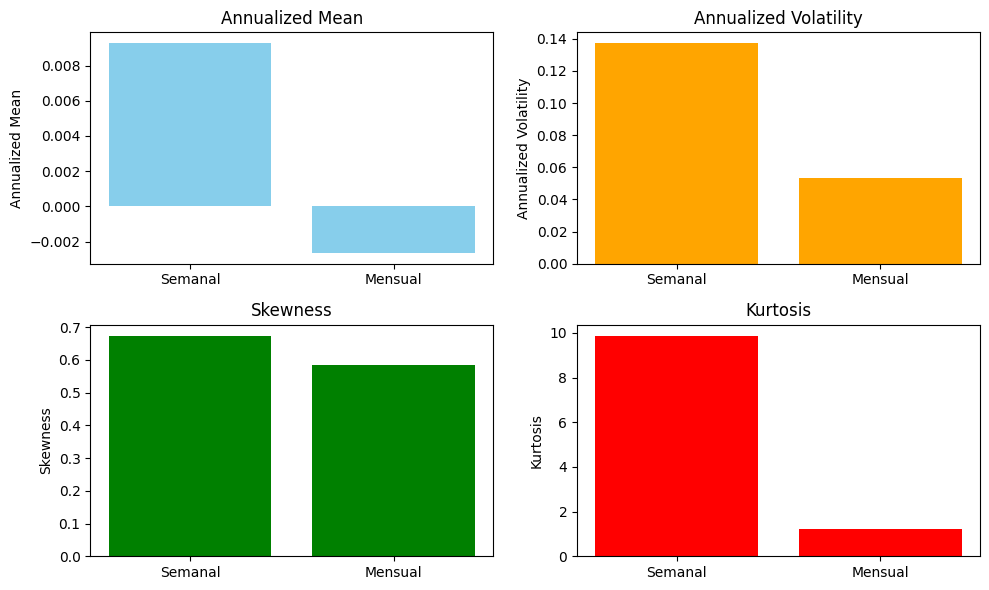

In [10]:
# Create a figure for the plots of the Retorno Mayor (Daily, Weekly, Monthly statistics)
plt.figure(figsize=(10, 6))  # Set the figure size

# Subplot for the Annualized Mean
plt.subplot(2, 2, 1)  # Create a 2x2 grid of subplots and select the first subplot
plt.bar(['Semanal', 'Mensual'], estadisticas_mayor_df.loc['Media Anualizada', ['Semanal', 'Mensual']], color='skyblue')  # Bar plot for weekly and monthly annualized mean
plt.title('Annualized Mean')  # Set the title of the plot
plt.ylabel('Annualized Mean')  # Set the label for the y-axis

# Subplot for the Annualized Volatility
plt.subplot(2, 2, 2)  # Select the second subplot in the 2x2 grid
plt.bar(['Semanal', 'Mensual'], estadisticas_mayor_df.loc['Volatilidad Anualizada', ['Semanal', 'Mensual']], color='orange')  # Bar plot for weekly and monthly annualized volatility
plt.title('Annualized Volatility')  # Set the title of the plot
plt.ylabel('Annualized Volatility')  # Set the label for the y-axis

# Subplot for the Skewness
plt.subplot(2, 2, 3)  # Select the third subplot in the 2x2 grid
plt.bar(['Semanal', 'Mensual'], estadisticas_mayor_df.loc['Skewness', ['Semanal', 'Mensual']], color='green')  # Bar plot for weekly and monthly skewness
plt.title('Skewness')  # Set the title of the plot
plt.ylabel('Skewness')  # Set the label for the y-axis

# Subplot for the Kurtosis
plt.subplot(2, 2, 4)  # Select the fourth subplot in the 2x2 grid
plt.bar(['Semanal', 'Mensual'], estadisticas_mayor_df.loc['Kurtosis', ['Semanal', 'Mensual']], color='red')  # Bar plot for weekly and monthly kurtosis
plt.title('Kurtosis')  # Set the title of the plot
plt.ylabel('Kurtosis')  # Set the label for the y-axis

# Adjust the layout to avoid overlapping and improve visualization
plt.tight_layout()

# Display the figure
plt.show()


### Comparison of the Effect of Calculating Data with Weekly or Monthly Frequency

Based on the data provided for weekly and monthly returns, the following conclusions can be drawn:

#### 1. **Annualized Mean**:
- **Weekly: 0.009293** | **Monthly: -0.002667**
- The weekly returns show a **positive annualized mean** of 0.93%, while the monthly returns have a **negative annualized mean** of -0.27%. This suggests that the asset performs better when evaluated over shorter, weekly periods. Over the monthly horizon, losses accumulate, leading to a negative return.

#### 2. **Annualized Volatility**:
- **Weekly: 0.137099** | **Monthly: 0.053252**
- The weekly returns exhibit a **higher volatility** (13.71%) compared to the monthly returns (5.33%). This indicates that the asset is more volatile and exhibits larger price swings over shorter time periods. Monthly returns, by contrast, are less volatile as they smooth out the short-term fluctuations.

#### 3. **Skewness**:
- **Weekly: 0.673418** | **Monthly: 0.583507**
- Both the weekly and monthly returns display **positive skewness**, with the weekly returns being more positively skewed (0.67 vs. 0.58). This suggests that both weekly and monthly returns are skewed towards positive extremes, meaning that there are more frequent large positive returns than negative ones. However, this skewness is more pronounced on a weekly basis.

#### 4. **Kurtosis**:
- **Weekly: 9.870030** | **Monthly: 1.208024**
- The **kurtosis** of the weekly returns is extremely high (9.87), indicating the presence of **fat tails** and a higher probability of extreme events (large price changes). On the other hand, the kurtosis of the monthly returns (1.21) is much closer to that of a normal distribution, implying that extreme events are far less frequent when viewed on a monthly horizon.

### General Conclusion:
- **Weekly frequency**: The asset shows **positive returns** with **higher volatility**, **more frequent extreme price movements**, and a greater skew towards large positive returns. The high kurtosis also indicates a higher likelihood of extreme price fluctuations.
  
- **Monthly frequency**: The asset displays **negative returns** with **lower volatility** and **fewer extreme events**. Although skewness remains positive, indicating some potential for large gains, the overall return is negative, suggesting that the asset does not perform well on a longer horizon.

These findings highlight a **trade-off** between risk and return: investing with a **weekly** horizon may expose the investor to more risk but also offers greater potential for gains, while a **monthly** strategy reduces volatility but leads to losses.



___________________________________